# Customer Segmentation using Clustering

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')
sns.set_context('poster')

# Data
This data set comes from the UCI Machine Learning Repository (Called the Online Retail II dataset). Each observation is an invoice for a specific item. The data was in an Excel format but I converted it to a CSV in my previous notebook.

In [2]:
data = pd.read_csv('clean_customer_retail.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


# Pre-processing

Even though I did some cleaning in the EDA notebook, the data needs a little more preperation before I can do a cluster anaylsis on it. I transform the dataset to be customer-centric instead of invoice-centric.

In [4]:
data['Description'] = [x.replace(' ', '') for x in data['Description']]

In [5]:
print('Unique Stock Codes:', data['StockCode'].nunique())
print('Unique Descriptions:', data['Description'].nunique())

Unique Stock Codes: 4588
Unique Descriptions: 5117


There appears to be a mismatch between unique stock codes and unique descriptions. There is  more room for error with descriptions so the data just might not be clean leading to more unique entries. Because of this, I will use Stock Codes for the intial clustering. 

In [17]:
# Generate a table with invoice numers as the focus
invoice = data[['Invoice', 'StockCode', 'Quantity']]
invoice = invoice.pivot_table(index='Invoice', columns='StockCode', values='Quantity')
invoice = invoice.fillna(0)

# Generate a Customer ID to Invoice number mapping
customers = data[['Customer ID', 'Invoice']]
customers = customers.groupby('Invoice').head(1)

# Add Customer IDs to spread data
data_prep = invoice
data_prep = customers.merge(data_prep, how='right', on='Invoice')

# Create revenue column
revenue = data[['Invoice','Revenue']]
revenue = revenue.groupby('Invoice').sum()
data_prep = data_prep.merge(revenue, how='left', on='Invoice')

# Drop Invoice because it's no longer necessary
data_prep.drop('Invoice', axis=1, inplace=True)

# Center the table on each independent customer
data_prep = data_prep.groupby('Customer ID').sum()

# Create total orders per customer column
orders = data.groupby('Customer ID')['Invoice'].nunique()
data_prep = data_prep.merge(orders, how='left', on='Customer ID')
data_prep['Orders'] = data_prep['Invoice']
data_prep.drop('Invoice', axis=1, inplace=True)

# Create Item Column
customer_totals = data_prep.drop(['Revenue', 'Orders'], axis=1)
customer_totals['Items'] = customer_totals.sum(axis=1)
customer_totals = customer_totals[['Items']]
data_prep = data_prep.merge(customer_totals, how='left', on='Customer ID')

# Create columns for avg items per order and avg revenue per order and avg rev per item
data_prep['AvgItemsOrder'] = data_prep['Items']/data_prep['Orders']
data_prep['AvgRevenueOrder'] = data_prep['Revenue']/data_prep['Orders']
data_prep['AvgRevenueItem'] = data_prep['Revenue']/data_prep['Items']

# Add countries column
# countries = data[['Customer ID', 'Country']]
# countries = countries.groupby('Customer ID').head(1)
# data_prep = data_prep.merge(countries, how='left', on='Customer ID')

In [18]:
data_prep.head()

,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,10133,...,90214Z,C2,PADS,SP1002,Revenue,Orders,Items,AvgItemsOrder,AvgRevenueOrder,AvgRevenueItem
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,169.36,2,24.0,12.000000,84.680,7.056667
12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5383.72,8,2727.0,340.875000,672.965,1.974228
12348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,816.24,4,1048.0,262.000000,204.060,0.778855
12349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3678.69,3,1621.0,540.333333,1226.230,2.269395
12350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,294.40,1,196.0,196.000000,294.400,1.502041


# Clustering

In [25]:
# Scale data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

prep_scaled = scaler.fit_transform(data_prep)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## K-Means Clustering

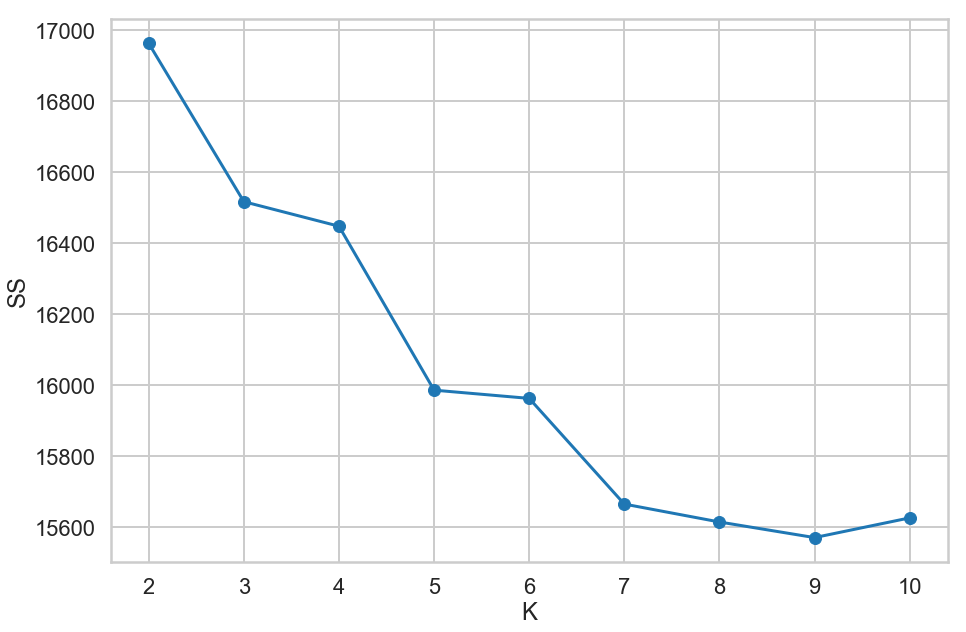

In [28]:
from sklearn.cluster import KMeans

SSs = []
for k in range(2,11):
    model = KMeans(n_clusters=k, random_state=13)
    model.fit(prep_scaled)
    SSs.append(model.inertia_)

fig, ax = plt.subplots(1, figsize=(15, 10))
plt.plot(range(2,11), SSs, '-o')
plt.xlabel('K')
plt.ylabel('SS')
plt.show()    